# install packages

In [ ]:
!pip install datasets
!pip install spacy
!pip install transformers
!pip install hazm
!pip install sentencepiece
!pip install gensim

^C


# import packages

In [1]:
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset,DataLoader
from typing import Iterable, List
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import random
from transformers import AutoTokenizer
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, trainers
from transformers import MBartTokenizer

# Download dataset

NOTE: Loading some samples of dataset

In [3]:
from datasets import load_dataset

# Load the Global Voices English-Persian translation dataset
dataset = load_dataset("persiannlp/parsinlu_translation_en_fa", split='train')

# Print a sample of the dataset
print("Sample English-Persian sentence pair:")
print(dataset[0])

KeyboardInterrupt: 

In [265]:
print(len(dataset))

1621665


In [266]:
dataset.save_to_disk('local_dataset')

In [18]:
# Randomly sample 20,000 examples from the dataset
sample_size = len(dataset)
sampled_dataset = dataset.shuffle(seed=42).select(range(sample_size))

NameError: name 'dataset' is not defined

In [268]:
persian_sentences = [item['targets'][0].encode('latin1').decode('utf-8') for item in sampled_dataset]

UnicodeEncodeError: 'latin-1' codec can't encode character '\u0637' in position 0: ordinal not in range(256)

In [14]:
# Extract Persian sentences without re-encoding
persian_sentences = [item['targets'][0] for item in sampled_dataset if 'targets' in item and item['targets']]


In [ ]:
english_sentences = [item['source'] for item in sampled_dataset]

In [10]:
persian_sentences[:4]

['ظˆ ط³ط¹غŒ ع©ط±ط¯ ط®ظˆط¯ ط±ط§ ط¨ظ‡ ط§ظˆ ط¨ط±ط³ط§ظ†ط¯طŒ ط§ظ…ط§ ع†ظˆظ† ط¨ظ‡ ط¢ظ† ظ†ظ‚ط·ظ‡ ط±ط³غŒط¯ ط¯ط®طھط±ع© ط±ظپطھظ‡ ط¨ظˆط¯.',
 'ظˆ طھط§ ع†ظ†ط¯ ظ„ط\xadط¸ظ‡ ط¯غŒع¯ط± ظ…ظˆط¶ظˆط¹ ط¨ط¯ظ‡غŒ ط¨ظ‡ â€Œع©ط§ط³ط¨â€Œظ‡ط§غŒ ظ…ط\xadظ„ ع©ط§ظ… ظ„ط§ ط§ط² ط°ظ‡ظ†ط´ ظ…ط\xadظˆ ظ…غŒâ€Œط´ط¯.',
 'ط¨ط¹ط¯ ظ‡ظ… ط²غŒط± ظ„ط¨غŒ ع¯ظپطھظ…: ظ¾ط¯ط±! ظ…غŒâ€Œط´ظ‡ ط³ط§ع©طھ ط¨ظ‡ ط´غŒطں',
 'ط§ظˆ ظپظ‚ط· ط¯ظˆط³طھ ظ…ظ† ط¨ظˆط¯. ط·ظˆط±غŒ ع©ظ‡ ظ…غŒâ€Œط¨ط§غŒط³طھ ط¨ط§ط´ط¯.']

In [ ]:
# Save sentences to a text file (BPE requires input in file format)
with open("persian_corpus.txt", "w", encoding="utf-8") as f:
    for sentence in persian_sentences:
        f.write(sentence + "\n")

In [ ]:
with open("english_corpus.txt", "w", encoding="utf-8") as f:
    for sentence in english_sentences:
        f.write(sentence + "\n")

# 1-1-tokenization

### 1. different tokenization

In [2]:
import spacy
from hazm import word_tokenize
from transformers import AutoTokenizer
from transformers import MBartTokenizer

# Sample Persian text
text_fa = "من در حال یادگیری پردازش زبان طبیعی هستم و عاشق هوش مصنوعی و پردازشگرها هستم"

# Word-based tokenization using Hazm
word_tokens = word_tokenize(text_fa) 
print("توکن‌های مبتنی بر واژه (Hazm):", word_tokens)

# Tokenize with BERT (subword-based)
subword_based_tokenizer = MBartTokenizer.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")
subword_based_output = subword_based_tokenizer(text_fa)
subword_tokens = subword_based_tokenizer.convert_ids_to_tokens(subword_based_output['input_ids'])
print("توکن‌های مبتنی بر زیرواژه (Subword):", subword_tokens)



توکن‌های مبتنی بر واژه (Hazm): ['من', 'در', 'حال', 'یادگیری', 'پردازش', 'زبان', 'طبیعی', 'هستم', 'و', 'عاشق', 'هوش', 'مصنوعی', 'و', 'پردازشگرها', 'هستم']


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'MBart50Tokenizer'. 
The class this function is called from is 'MBartTokenizer'.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


توکن‌های مبتنی بر زیرواژه (Subword): ['▁من', '▁در', '▁حال', '▁یادگیری', '▁پرداز', 'ش', '▁زبان', '▁طبیعی', '▁هستم', '▁و', '▁عاشق', '▁هوش', '▁مصنوعی', '▁و', '▁پرداز', 'ش', 'گر', 'ها', '▁هستم', '</s>', 'en_XX']


### 2.Train a sentencepiece tokenizer for persian

In [3]:
import sentencepiece as spm

file_path = './Persian/'
# Path to the corpus file
corpus_file = file_path + "persian_corpus.txt"

# Set parameters for training the tokenizer
vocab_size = 21000  # Adjust the vocabulary size
character_coverage = 0.999 # Coverage of characters in the training data
model_prefix = file_path + "persian_spm"  # Prefix for saving the model and vocab
model_type = 'bpe'

# Train the SentencePiece model
spm.SentencePieceTrainer.train(input=corpus_file, model_prefix=model_prefix, vocab_size=vocab_size,
 character_coverage=character_coverage, model_type=model_type)
# end of your code

print("Training complete! Model saved as 'persian_spm.model' and vocab as 'persian_spm.vocab'")


Training complete! Model saved as 'persian_spm.model' and vocab as 'persian_spm.vocab'


### Examples

In [4]:
# Load the trained SentencePiece model
# if you did optional part you comment the next 2 lines
sp = spm.SentencePieceProcessor()
sp.load(file_path + 'persian_spm.model')

# Tokenize a sample Persian sentence
sentence = "این یک جمله خبری است."
tokens = sp.encode(sentence, out_type=str)
print("Tokenized sentence:", tokens)

# Convert the tokens back to the sentence
decoded_sentence = sp.decode(tokens)
print("Decoded sentence:", decoded_sentence)


Tokenized sentence: ['▁این', '▁یک', '▁جمله', '▁خبری', '▁است', '.']
Decoded sentence: این یک جمله خبری است.


In [5]:
sentence = "پردازش تصویر"
tokens = sp.encode(sentence, out_type=str)
print("Tokenized sentence:", tokens)


Tokenized sentence: ['▁پرداز', 'ش', '▁تصویر']


In [6]:
sentence = "من به درس خواندن علاقه دارم "
tokens = sp.encode(sentence, out_type=str)
print("Tokenized sentence:", tokens)


Tokenized sentence: ['▁من', '▁به', '▁درس', '▁خواندن', '▁علاقه', '▁دارم']


In [7]:
sentence = "بانو حالتون چطوره؟"
tokens = sp.encode(sentence, out_type=str)
print("Tokenized sentence:", tokens)


Tokenized sentence: ['▁بانو', '▁حالتون', '▁چطوره', '؟']


In [8]:
sentence = "من کتابها را دوست دارم"
tokens = sp.tokenize(sentence, out_type=str)
print("Tokenized sentence:", tokens)

Tokenized sentence: ['▁من', '▁کتابها', '▁را', '▁دوست', '▁دارم']


In [9]:
tokens[0:2]

['▁من', '▁کتابها']

In [10]:
sentence = "من به زبان فارسی صحبت میکنم"
tokens = sp.encode(sentence, out_type=str)
print("Tokenized sentence:", tokens)

Tokenized sentence: ['▁من', '▁به', '▁زبان', '▁فارسی', '▁صحبت', '▁میکنم']


In [11]:
sentence = "من در حال یادگیری پردازش زبان طبیعی هستم و عاشق هوش مصنوعی و پردازشگرها هستم"
tokens = sp.encode(sentence, out_type=str)
print("Tokenized sentence:", tokens)

Tokenized sentence: ['▁من', '▁در', '▁حال', '▁یادگیری', '▁پرداز', 'ش', '▁زبان', '▁طبیعی', '▁هستم', '▁و', '▁عاشق', '▁هوش', '▁مصنوعی', '▁و', '▁پرداز', 'ش', 'گرها', '▁هستم']


# Pre-train a persian tokenizer

In [12]:
from hazm import Normalizer, word_tokenize, stopwords_list, Stemmer

normalizer = Normalizer()
stemmer = Stemmer()

def preprocess_text(text):
    # print(text)
    normalized_text = normalizer.normalize(text)
    # print(f'after normalization: {normalized_text}')
    tokens = word_tokenize(normalized_text)
    # tokens = sp.encode(text, out_type=str)
    stopwords = stopwords_list()
    # stemmed_tokens = [stemmer.stem(word) for word in tokens]
    # print(f'after stemming: {stemmed_tokens}')
    tokens_without_stopwords = [word for word in tokens if word not in stopwords]
    # print(f'after removing stopword: {tokens_without_stopwords}')
    
    return tokens_without_stopwords

In [13]:
import re 

# Tokenized Persian sentences (list of lists of tokens)
tokenized_sentences = []
with open(file_path + 'persian_corpus.txt', 'r', encoding="utf-8") as f:
    for text in f.readlines():
        # tokens = word_tokenize(text)
        tokens = sp.encode(text.strip(), out_type=str)
        tokens = [re.sub(r'[▁]', '', token).strip() for token in tokens]
        # tokens = preprocess_text(text)
        tokenized_sentences.append(tokens)

In [14]:
from gensim.models import Word2Vec

vector_size=300
window=5
min_count=1
workers=8

# Train Word2Vec
word2vec_model = Word2Vec(tokenized_sentences, min_count=min_count, vector_size=vector_size, window=window, workers=workers)

# Save the Word2Vec model
word2vec_model.save("word2vec_persian.model")

In [15]:
print(len(tokenized_sentences))

1621665


In [16]:
import matplotlib.pyplot as plt

# Load your trained Word2Vec model
# Replace 'your_model_path' with the path to your Word2Vec model
model = Word2Vec.load("./word2vec_persian.model")

## 1. Check most similar words

In [17]:
def most_similar_words(word):
    try:
        similar_words = model.wv.most_similar(word, topn=10)
        print(f"Most similar words to '{word}':")
        for similar_word, similarity in similar_words:
            print(f"  {similar_word}: {similarity:.4f}")
    except KeyError:
        print(f"'{word}' not in vocabulary!")

# Test with an example word
most_similar_words("پزشک")

Most similar words to 'پزشک':
  دربار: 0.6530
  دستیار: 0.6275
  داروخانه: 0.5696
  خدمتکار: 0.5312
  یانگوم: 0.5299
  پزشکی: 0.5254
  پزشکان: 0.5221
  سلطنتی: 0.5125
  ارشد: 0.5115
  بانوی: 0.5106


In [18]:
most_similar_words("خوب")

Most similar words to 'خوب':
  خب: 0.6850
  بهتر: 0.5464
  خوبه: 0.5397
  خرسندم: 0.4722
  متأسفم: 0.4662
  ممنون: 0.4593
  آسونه: 0.4508
  بهترم: 0.4480
  خوشگل: 0.4465
  خوبست: 0.4442


# 3. Visualize embeddings using PCA


In [ ]:
for word in ["شاه", "شکوه", "تاج"]:
    if word in model.wv:
        print(f"'{word}' is in the vocabulary.")
    else:
        print(f"'{word}' is NOT in the vocabulary.")

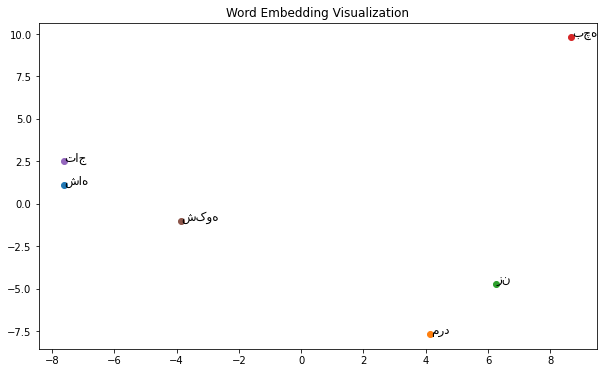

In [20]:
from sklearn.decomposition import PCA
def visualize_embeddings(words):
    try:
        word_vectors = [model.wv[word] for word in words if word in model.wv]
        # if not word_vectors:
        #     print("No words found in the vocabulary.")
        #     return
        pca = PCA(n_components=2)
        reduced_vectors = pca.fit_transform(word_vectors)

        plt.figure(figsize=(10, 6))
        for word, vector in zip(words, reduced_vectors):
            plt.scatter(vector[0], vector[1])
            plt.text(vector[0] + 0.02, vector[1] + 0.02, word, fontsize=12)
        plt.title("Word Embedding Visualization")
        plt.show()
    except KeyError as e:
        print(f"Error: {e}")

# Test visualization with example words
words_to_visualize = ["شاه", "مرد", "زن", "بچه", "تاج", "شکوه"]
visualize_embeddings(words_to_visualize)

# Pre-train a english tokenizer

### Train a sentencepiece tokenizer for English

In [22]:
file_path = './English/'

In [25]:
import sentencepiece as spm

# Path to the corpus file
corpus_file = file_path + "english_corpus.txt"

# Set parameters for training the tokenizer
vocab_size = 20000  # Adjust the vocabulary size
character_coverage = 0.995 # Coverage of characters in the training data
model_prefix = file_path + "english_spm"  # Prefix for saving the model and vocab
model_type = 'bpe'

# Train the SentencePiece model
spm.SentencePieceTrainer.train(input=corpus_file, model_prefix=model_prefix, vocab_size=vocab_size, character_coverage=character_coverage,
 model_type=model_type)
# end of your code

print("Training complete! Model saved as 'english_spm.model' and vocab as 'english_spm.vocab'")


Training complete! Model saved as 'english_spm.model' and vocab as 'english_spm.vocab'


In [26]:
en_sp = spm.SentencePieceProcessor()
en_sp.load(file_path + 'english_spm.model')

text = en_sp.encode('how are you?', out_type=str)
print(text)

['▁how', '▁are', '▁you', '?']


In [28]:
import re 

# Tokenized English sentences (list of lists of tokens)
en_tokenized_sentences = []
with open(file_path + 'english_corpus.txt', 'r') as f:
    for text in f.readlines():
        # tokens = word_tokenize(text)
        tokens = en_sp.encode(text.strip(), out_type=str)
        tokens = [re.sub(r'[▁]', '', token).strip() for token in tokens]
        en_tokenized_sentences.append(tokens)

In [29]:
from gensim.models import Word2Vec

mb = MBartTokenizer.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")

# Tokenized English sentences (list of lists of tokens)
vector_size=300
window=5
min_count=3
workers=4

# Train Word2Vec
word2vec_model = Word2Vec(en_tokenized_sentences, min_count=min_count, vector_size=vector_size, window=window, workers=workers)

# Save the Word2Vec model
word2vec_model.save(file_path + "word2vec_english.model")


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'MBart50Tokenizer'. 
The class this function is called from is 'MBartTokenizer'.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## 1. Check most similar words

In [30]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load your trained Word2Vec model
# Replace 'your_model_path' with the path to your Word2Vec model
model = Word2Vec.load(file_path + "word2vec_english.model")

def most_similar_words(word):
    try:
        similar_words = model.wv.most_similar(word, topn=10)
        print(f"Most similar words to '{word}':")
        for similar_word, similarity in similar_words:
            print(f"\t{similar_word}: {similarity:.4f}")
    except KeyError:
        print(f"'{word}' not in vocabulary!")

# Test with an example word
most_similar_words("boy")

Most similar words to 'boy':
	girl: 0.7557
	lad: 0.6789
	child: 0.6520
	fellow: 0.6469
	lawyer: 0.6206
	kid: 0.5978
	man: 0.5909
	guy: 0.5896
	student: 0.5893
	woman: 0.5819


In [31]:
most_similar_words("girl")

Most similar words to 'girl':
	woman: 0.7926
	boy: 0.7557
	child: 0.7294
	creature: 0.6737
	person: 0.6231
	man: 0.6224
	guy: 0.6090
	widow: 0.6067
	fellow: 0.5878
	lady: 0.5826


In [32]:
most_similar_words("man")

Most similar words to 'man':
	woman: 0.7708
	gentleman: 0.7317
	soldier: 0.7201
	person: 0.6871
	fellow: 0.6831
	sailor: 0.6520
	creature: 0.6251
	beggar: 0.6224
	girl: 0.6224
	rascal: 0.6165


In [33]:
most_similar_words("doctor")

Most similar words to 'doctor':
	lawyer: 0.7172
	prince: 0.6683
	priest: 0.6480
	captain: 0.6350
	prisoner: 0.6302
	nurse: 0.6211
	steward: 0.6092
	housekeeper: 0.6074
	governor: 0.6068
	princess: 0.6026


## 3. Visualize embeddings using PCA

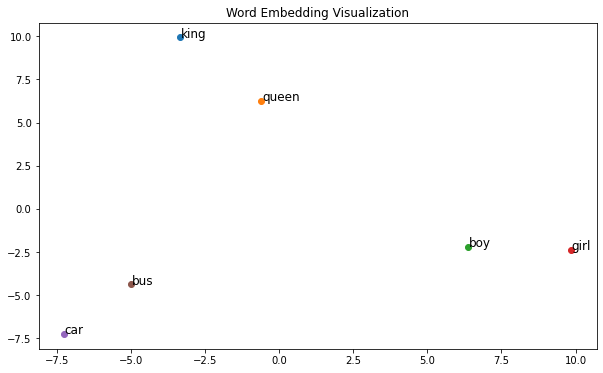

: 

In [ ]:

def visualize_embeddings(words):
    try:
        word_vectors = [model.wv[word] for word in words]
        pca = PCA(n_components=2)
        reduced_vectors = pca.fit_transform(word_vectors)

        plt.figure(figsize=(10, 6))
        for word, vector in zip(words, reduced_vectors):
            plt.scatter(vector[0], vector[1])
            plt.text(vector[0] + 0.02, vector[1] + 0.02, word, fontsize=12)
        plt.title("Word Embedding Visualization")
        plt.show()
    except KeyError as e:
        print(f"Error: {e}")

# Test visualization with example words
words_to_visualize = ["king", "queen", "boy","girl","car", "bus"]
visualize_embeddings(words_to_visualize)